In [1]:
#!/usr/bin/env python
# coding: utf-8
%reset -f
# Import a bunch of libraries
import gc
gc.collect()
%reload_ext autoreload
%autoreload 2


from opticalc_330 import *
from ipywidgets import *

## OPTIONAL
from pprint import pprint

from IPython.display import Image, display
get_ipython().magic(u'matplotlib inline')
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import os
import time # For creating folders with unique names, in chronological order.
import datetime
import re #RegEx used to find file names for curve fitting

from scipy.signal import argrelextrema # Used for making plots versus AOI of the peak-to-peak absorbance
import scipy.fftpack as ft # Used for the Hilbert (Kramers-Kronig) transform
import sympy as sp # used for the solveDrude() function; could be eliminated by providing the exact analytical expression
import csv # used for exporting data as .csv files
from ipywidgets import interact # used for fitting part of program
import ipywidgets as widgets # used for fitting part of program

import itertools # Used for generating n-phase expressions for Bruggeman EMT and Wiener Limits.

# Libraries used for plotting ellipsoids to visualize the coordinates when setting up a shape-anisotropic system
# import numpy as np #
# from matplotlib import pyplot as plt #
# import itertools #
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Arc
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.ticker import StrMethodFormatter # for formatting strings on plots when creating GIFs
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "monospace",})
# print(plt.rcParams["font.monospace"][0])

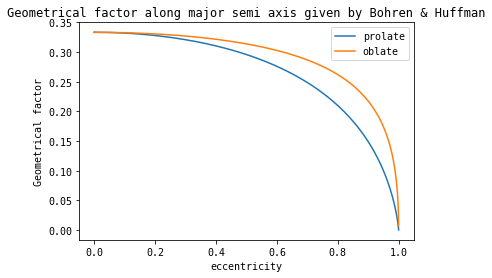

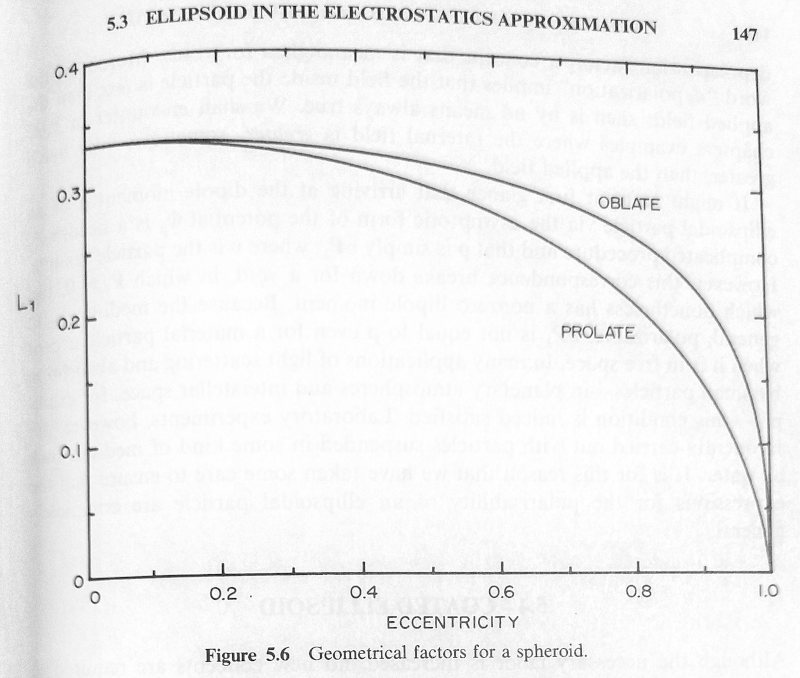

In [2]:
# DEMO_001
# Plotting geometrical factors for prolate and oblate ellipsoids as a function of eccentricity
# (Fig 5.6 on page 147 in "Absorption and Scattering of Light by Small Particles" by Bohren & Huffman, ISBN-13: 978-0471057727)
a = 1 # major semi axis length (actual number here does not matter)
pts = 20000 # number of data points
m = materials("frequency", 60, 1500, 1700, 100) ## just create some materials object with random parameters to access getGeometricFactor() function.

# def altGeom(thickness, molec, ratio1):
#     a1 = float(ratio1*thickness/2)
#     c1 = float(thickness/2)
#     a2 = float(molec + a1)
#     c2 = float(molec + c1)
#     ratio2 = float(a2/c2)
#     Da1 = (1/(float(ratio1)**2 - 1))*((float(ratio1)/np.sqrt(float(ratio1)**2-1))*np.log(float(ratio1) + np.sqrt(float(ratio1)**2 - 1))-1)
#     Da2 = (1/(ratio2**2 - 1))*((ratio2/np.sqrt(ratio2**2-1))*np.log(ratio2 + np.sqrt(ratio2**2 - 1))-1)
#     Dc1 = (1/(2*(float(ratio1)**2 - 1)))*(float(ratio1)**2 - (float(ratio1)/np.sqrt(float(ratio1)**2-1))*np.log(float(ratio1) + np.sqrt(float(ratio1)**2-1)))
#     Dc2 = (1/(2*(ratio2**2 - 1)))*(ratio2**2 - (ratio2/np.sqrt(ratio2**2-1))*np.log(ratio2 + np.sqrt(ratio2**2-1)))
    
#     altD1 = m.getGeometricFactor(a1, c1, c1, True)
#     altD2 = m.getGeometricFactor(a2, c2, c2, True)
    
#     print("old", Da1, Dc1)
#     print("new", altD1[0], altD1[2])
#     print("old", Da2, Dc2)
#     print("new", altD2[0], altD2[2])
#     return

# altGeom(10, 1, 3)
    
prolate_La = np.zeros(pts)
prolate_Lc = np.zeros(pts)
oblate_La = np.zeros(pts)
oblate_Lc = np.zeros(pts)
eccentricity = np.zeros(pts)

for i in range(pts): ## This runs from eccentricity = 0 to one increment less than eccentricity = 1 (a,b,c are undefined for eccentricity = 1)    
    eccentricity[i] = (i)/(pts)
    c = np.sqrt(-1*(a**2) * (eccentricity[i]**2 - 1))
#     print(a, c)
    prolate = m.getGeometricFactor(a,c,c) # Prolate: b = c
    oblate = m.getGeometricFactor(a,a,c) # Oblate: b = a
    prolate_La[i] = prolate[0]
    prolate_Lc[i] = prolate[2]
    oblate_La[i] = oblate[0]
    oblate_Lc[i] = oblate[2]

# print("prolate", prolate_La)
# print("oblate", oblate_La)
plt.plot(eccentricity, prolate_La, eccentricity, oblate_La)
plt.ylabel('Geometrical factor')
plt.xlabel('eccentricity')
plt.title("Geometrical factor along major semi axis given by Bohren & Huffman")
plt.legend(('prolate', 'oblate'), fontsize=10)
plt.show()
display(Image("img/DEMO_001_bohren_huffman_1980.png", width = 400))

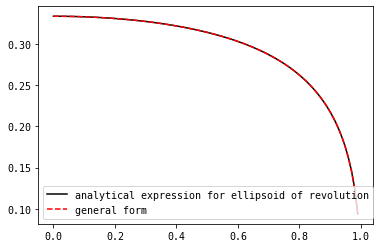

In [3]:
# DEMO_002
# Testing out general formula (integration), versus analytical expressions for prolate and oblate spheroids.
axis = 0 ## (0, 1, 2)  for (La, Lb, Lc)
a = 1
pts = 100
m = materials("frequency", 60, 1500, 1700, 200)
analytic = np.zeros(pts)
general = np.zeros(pts)
eccentricity = np.zeros(pts)

for i in range(pts):
    eccentricity[i] = (i)/(pts)
    c = np.sqrt(-1*(a**2) * (eccentricity[i]**2 - 1))
    b = a # (b=a for oblate, b=c for prolate)
    analytic[i] = m.getGeometricFactor(a, b, c)[axis]
    general[i] = m.getGeometricFactor(a, b, c, True)[axis]
    
plt.plot(eccentricity, analytic, "k-", eccentricity, general, "r--")
plt.legend(('analytical expression for ellipsoid of revolution', 'general form'), fontsize=10)
plt.show()



## TO get 4-dimensional plots (Li as a function of a, b, c) for an arbitrarily shaped ellipsoid
# axis = 1 ## (0, 1, 2)  for (a, b, c)
# a = 0
# b = 0
# c = 0
# pts = 20
# m = materials("frequency", 60, 1500, 1700, 1)
# geoA = np.zeros((pts, pts, pts))
# geoB = np.zeros((pts, pts, pts))
# geoC = np.zeros((pts, pts, pts))

# for aCount in range(pts):
#     a += aCount/pts
#     for bCount in range(pts):
#         b += bCount/pts
#         for cCount in range(pts):
#             c += cCount/pts
#             (geoA[aCount][bCount][cCount], geoB[aCount][bCount][cCount], geoC[aCount][bCount][cCount]) = m.getGeneral(a, b, c)


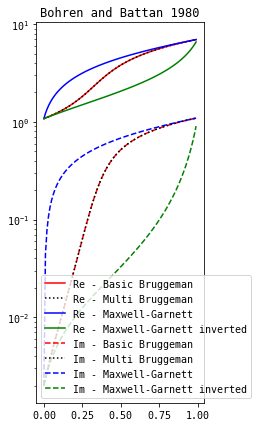

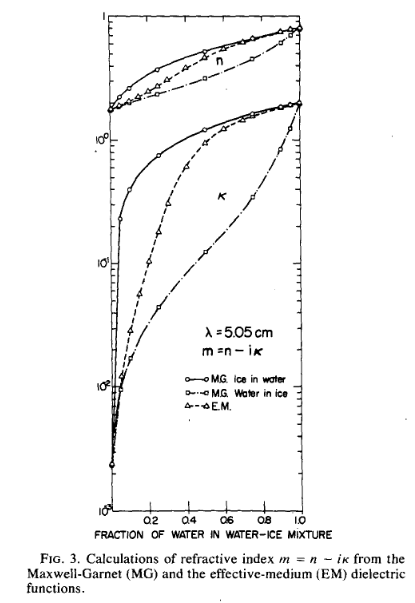

In [4]:
# DEMO_003 demo of the basic 2-phase expressions for Maxwell-Garnett and Bruggeman. 
# See 1980 Bohren and Battan.   https://doi.org/10.1175/1520-0469(1980)037<1821:RBBIPP>2.0.CO;2
m03 = materials("frequency", 60, 1000, 1002, 100)
# approximate values from various online sources
m03.setFixed("water", 7 , 1.1)
m03.setFixed("ice", 1.08, 0.002)
## The values below were obtained by using Theiss' Digit program
# m03.setFixed("water", 10**(0.8943), 10**(0.2893))
# m03.setFixed("ice", 10**(0.2247) , 10**(-2.6417))
fill = np.arange(0, 1, 0.01)
basic_brug = []
multi_brug = []
maxg = []
maxgalt = []
for i in range(len(fill)):
    m03.setBasicBruggeman("BB", "ice", "water", 1-fill[i])
    basic_brug.append(m03.matDict["BB"]["eta"][0])
    m03.setMultiBruggeman("MB", ["ice", "water"], [1-fill[i], fill[i]])
    multi_brug.append(m03.matDict["MB"]["eta"][0])
    m03.setBasicMaxwellGarnett("BMG", "ice", "water", 1-fill[i])
    maxg.append(m03.matDict["BMG"]["eta"][0])
    m03.setBasicMaxwellGarnett("BMGalt", "water", "ice", fill[i])
    maxgalt.append(m03.matDict["BMGalt"]["eta"][0])


plt.figure(figsize=(3,7))
plt.title("Bohren and Battan 1980")
plt.plot(fill, np.real(basic_brug), "r", fill, np.real(multi_brug), "k:", fill, np.real(maxg), "b", fill, np.real(maxgalt), "g", fill, np.imag(basic_brug), "r--", fill, np.imag(multi_brug), "k:", fill, np.imag(maxg), "b--", fill, np.imag(maxgalt), "g--")
plt.legend(["Re - Basic Bruggeman", "Re - Multi Bruggeman", "Re - Maxwell-Garnett", "Re - Maxwell-Garnett inverted", "Im - Basic Bruggeman", "Im - Multi Bruggeman", "Im - Maxwell-Garnett", "Im - Maxwell-Garnett inverted"])
plt.yscale("log")
plt.show()

Image("img/DEMO_003_reference_fig3_in_bohren_and_battan.png")

In [5]:
# DEMO_004
# Algorithm for product of variable number of binomial terms

# The purpose of this sheet is to clearly describe how to calculate the effective permittivity for n-phase
# Bruggeman effective medium theory

# Consider a product of binomial terms in the form:
# (a1 + a2*x)*(b1 + b2*x)*(c1 + c2*x)*...*(m1 + m2*x)*(n1 + n2*x)

# When this is expanded fully, we get a polynomial of degree N, where N is the number of binomial factors of form (constant + constant*x).

# The coefficient for a particular of degree of x are given by:
# x^0     => a1*b1*c1*...m1*n1
# x^1     => a2*b1*c1*...*m1*n1 + a1*b2*c1*...*m1*n1 + a1*b1*c2*...*m1*n1 + ... + a1*b1*c1*...*m2*n1 + a1*b1*c1*...*m1*n2
# x^2     => a2*b2*c1*...*m1*n1 + a2*b1*c2*...*m1*n1 + ... + a2*b1*c1*...*m2*n1 + a2*b1*c1*...*m1*n2
#            + a1*b2*c2*...*n1 + ... + a1*b2*c1*...*m2*n1 + a1*b2*c1*...*m1*n2
#            + ... + a1*b1*c2*...*m2*n1 + a1*b1*c2*...*m1*n2
#            + ...
#            + a1*b1*c1*...*m2*n2
# ...
# ...
# x^(N-1) => a1*b2*c2*...*m2*n2 + a2*b1*c2*...*m2*n2 + a2*b2*c1*...*m2*n2 + ... + a2*b2*c2*...*m1*n2 + a2*b2*c2*...*m2*n1
# x^N     => a2*b2*c2*...*m2*n2


# The polynomial can be represented in the form of factored binomial terms using two arrays:
# ARR1 = [a1, b1, c1, ..., m1, n1]
# ARR2 = [a2, b2, c2, ..., m2, n2]

# To calculate the coefficient of degree zero, we simply multiply the terms of ARR1.
# To calculate the coefficient of degree one, we replace the first term in ARR1 by the first term in ARR2, then multiply all terms.
# Then we replace the second term in ARR1 by the second term in ARR2 and multiply all terms.
# 
# Thus, to calculate the coefficient of degree n, we add all the permutations formed by replacing n terms in ARR1 by the corresponding term in ARR2.

a1, a2, b1, b2, c1, c2, d1, d2, e1, e2 = sp.symbols(["a1", "a2", "b1", "b2", "c1", "c2", "d1", "d2", "e1", "e2"])
ARR1 = [a1, b1, c1, d1, e1]
ARR2 = [a2, b2, c2, d2, e2]

demo4 = materials("frequency", 60, 1000,2000, 100)
polycoef = demo4.binomialProdCoefs(ARR1, ARR2)
for i in range(len(polycoef)):
    print("coef of x^" + str(i) + " : " + str(polycoef[i]))

coef of x^0 : a1*b1*c1*d1*e1
coef of x^1 : a1*b1*c1*d1*e2 + a1*b1*c1*d2*e1 + a1*b1*c2*d1*e1 + a1*b2*c1*d1*e1 + a2*b1*c1*d1*e1
coef of x^2 : a1*b1*c1*d2*e2 + a1*b1*c2*d1*e2 + a1*b1*c2*d2*e1 + a1*b2*c1*d1*e2 + a1*b2*c1*d2*e1 + a1*b2*c2*d1*e1 + a2*b1*c1*d1*e2 + a2*b1*c1*d2*e1 + a2*b1*c2*d1*e1 + a2*b2*c1*d1*e1
coef of x^3 : a1*b1*c2*d2*e2 + a1*b2*c1*d2*e2 + a1*b2*c2*d1*e2 + a1*b2*c2*d2*e1 + a2*b1*c1*d2*e2 + a2*b1*c2*d1*e2 + a2*b1*c2*d2*e1 + a2*b2*c1*d1*e2 + a2*b2*c1*d2*e1 + a2*b2*c2*d1*e1
coef of x^4 : a1*b2*c2*d2*e2 + a2*b1*c2*d2*e2 + a2*b2*c1*d2*e2 + a2*b2*c2*d1*e2 + a2*b2*c2*d2*e1
coef of x^5 : a2*b2*c2*d2*e2


In [6]:
# DEMO_005
# Demonstration of plotting an ellipsoid with semi-axes a, b, c with any arbitrary orientation

fig = plt.figure(figsize=(10,10), dpi=300)
ax = fig.add_subplot(111, projection='3d') # Default is 443 not 111. 111 makes the axes equal, not stretched

drawEllipsoid(ax, 1,0.6,0.2, [[1, 1, 1], 20], "rodrigues") # For the point group of an ellipsoid, this is the same as rotating by [0, 0, 90]
# drawEllipsoid(1,0.6,0.2, [0, 0, 90], plotUnitVec = False)

axval = 1
ax.set_xlim3d([-axval, axval])
ax.set_ylim3d([-axval, axval])
ax.set_zlim3d([-axval, axval])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
plt.title('Off-axis, oriented ellipsoid, rotated 20' + u'\N{DEGREE SIGN}' + ' about the [111] axis')

ax.view_init(24, 50)

plt.draw()
plt.show()

print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))

AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

AttributeError: 'Arrow3D' object has no attribute 'do_3d_projection'

<Figure size 3000x3000 with 1 Axes>

In [ ]:
# DEMO_006
# Test of setCoatedEllipsoidAniso()
# Replicates figures 2c, 3d and 4d in: 10.1088/1361-6463/aa9606 (2017_zhao_mei_J._Phys._D _Appl._Phys._50_505001)

# Demonstration of Zhao and Mei coated ellipsoid - working.
# The effective permittivity of the coated ellipsoid: a tunable electromagnetic parameter approach
# Canxing Zhao and Zhonglei Mei 2017 J. Phys. D: Appl. Phys. 50 505001

def set(l):
    demo = materials("frequency", 60, 1E7/1000, 1E7/200, 3000)
    demo.setDrude("Ag", 9.2*UNIT_eV, 0.0212*UNIT_eV, 5)
    demo.setFixed("SiO2", np.sqrt(2.25))
    demo.setLorentz("org", [173], [20], 1.77, [12500])
    demo.setDrude("met_shell", 9*UNIT_eV, 0.1*UNIT_eV, 1)
    demo.setDrude("met_core", 1*UNIT_eV, 0.05*UNIT_eV, 10)
    dat2c = demo.setCoatedEllipsoidAniso("eps2c", "SiO2", "Ag", 15,10,10, lamda=l, rotMat=False)[:,1,1] # Need to select index eps_yy or eps_zz since I have to make a >= b >= c
    dat3d = demo.setCoatedEllipsoidAniso("eps3d", "Ag", "SiO2", 15,10,10, lamda=l, rotMat=False)[:,1,1]
    dat4d = demo.setCoatedEllipsoidAniso("eps4d", "met_core", "met_shell", 15,10,10, lamda=l, rotMat=False)[:,1,1]
    nu = demo.nu
    ld = 1E7/nu
    fig = plt.figure(figsize=(15,5))
    ax2c = fig.add_subplot(131)
    ax2c.plot(ld, np.real(dat2c), ld, np.imag(dat2c))
    ax2c.set_title("Fig 2c")
    ax3d = fig.add_subplot(132)
    ax3d.plot(ld, np.real(dat3d), ld, np.imag(dat3d))
    ax3d.set_title("Fig 3d")
    ax4d = fig.add_subplot(133)
    ax4d.plot(ld, np.real(dat4d), ld, np.imag(dat4d))
    ax4d.set_title("Fig 4d")
    plt.show()
    
interact(set, l=(0.,1.,0.01))

# def do(a,b,c,l):
#     demo = materials("frequency", 60, 1950, 2150, 100)
#     demo.importMat(["Au_Babar"])
#     demo.setLorentz("org", [173], [20], 1.77, [2050])
#     e = demo.setCoatedEllipsoid("aa", "Au_Babar", "org", a,b,c,l)
#     exx = e[:,0,0]
#     eyy = e[:,1,1]
#     ezz = e[:,2,2]
#     x = demo.nu
#     plt.plot(x, np.real(exx), x, np.imag(exx), x, np.real(eyy), x, np.imag(eyy), x, np.real(ezz), x, np.imag(ezz))
#     plt.legend(["Re exx", "Im exx", "Re eyy", "Im eyy", "Re ezz", "Im ezz"])
#     plt.show()
# interact(do, a=(1,10,1), b=(1,10,1), c=(1,10,1),l=(0.,1.,0.1))
display(Image("img/DEMO_006_zhao_mei_test_cases.png"))

In [ ]:
# DEMO_007
# Ohta and Ishida field strength plots
# https://doi.org/10.1364/AO.29.001952

figs07 = plt.figure(figsize=(10,10))

# Test calculation for Figure 2 in Ohta
mat = materials("aoi", 1000, 0, 90, 91)
mat.setFixed("n0", 1.0)
mat.setFixed("n0", 1.0)
mat.setFixed("n1a", 1.0)
mat.setFixed("n1b", 1.5)
mat.setFixed("n1c", 1.5, 0.5)
mat.setFixed("n2", 3.0, 30.0)

zdepth_fig2 = 9.999999999

a = phaseSys(3, mat)
a.setLayers(["n0", "n1a", "n2"])
a.setThicknesses([10])

b = phaseSys(3, mat)
b.setLayers(["n0", "n1b", "n2"])
b.setThicknesses([10])

c = phaseSys(3, mat)
c.setLayers(["n0", "n1c", "n2"])
c.setThicknesses([10])

Fza_10 = a.calcE(zdepth_fig2)['Fz']
Fzb_10 = b.calcE(zdepth_fig2)['Fz']
Fzc_10 = c.calcE(zdepth_fig2)['Fz']
ax2 = figs07.add_subplot(221)
ax2.plot(mat.aoi, Fza_10, mat.aoi, Fzb_10, mat.aoi, Fzc_10)
ax2.legend(("Fz a", "Fz b", "Fz c"), fontsize=10)
ax2.set_title("Fig 2")

# Fig 3 in Ohta
zdepth = np.linspace(-10, 20, 100)
Fza = np.zeros(len(zdepth))
Fzb = np.zeros(len(zdepth))
Fzc = np.zeros(len(zdepth))
for z in range(len(zdepth)):
    Fza[z] = a.calcE(zdepth[z])['Fz'][75]
    Fzb[z] = b.calcE(zdepth[z])['Fz'][75]
    Fzc[z] = c.calcE(zdepth[z])['Fz'][75]
ax3 = figs07.add_subplot(223)
ax3.plot(zdepth, Fza, zdepth, Fzb, zdepth, Fzc)
ax3.legend(["Fz a", "Fz b", "Fz c"])
ax3.set_title("Fig 3")

# Fig 4 in Ohta
mat = materials("aoi", 1000, 24.5, 24.7, 201)
mat.setFixed("n0", 2.4)
mat.setFixed("n1", 1.0)
mat.setFixed("n2a", 1.0)
mat.setFixed("n2b", 1.5)
mat.setFixed("n2c", 1.5, 0.5)
mat.setFixed("n3", 3.0, 30.0)

field = 'Fz'

a = phaseSys(4, mat)
a.setLayers(["n0", "n1", "n2a", "n3"])
a.setThicknesses([45760, 10])
Ea = a.calcE(45769.9999999)[field]

b = phaseSys(4, mat)
b.setLayers(["n0", "n1", "n2b", "n3"])
b.setThicknesses([44220, 10])
Eb = b.calcE(44229.999999999)[field]

c = phaseSys(4, mat)
c.setLayers(["n0", "n1", "n2c", "n3"])
c.setThicknesses([38600, 10])
Ec = c.calcE(38609.9999999)[field]

ax4 = figs07.add_subplot(222)
ax4.plot(mat.aoi, np.real(Ea), mat.aoi, np.real(Eb), mat.aoi, np.real(Ec))
ax4.legend(("Fz a", "b", "c"), fontsize=10)
ax4.set_title("Fig 4")

# Fig 5 in Ohta. Note: this is SLOW!
zdepth = np.linspace(-20000, 60000, 100)
Fza = np.zeros(len(zdepth))
Fzb = np.zeros(len(zdepth))
Fzc = np.zeros(len(zdepth))
for z in range(len(zdepth)):
    Fza[z] = a.calcE(zdepth[z])['Fz'][122] # zdepth[122] -> 24.622
    Fzb[z] = b.calcE(zdepth[z])['Fz'][126] # zdepth[126] -> 24.626
    Fzc[z] = c.calcE(zdepth[z])['Fz'][119] # zdepth[119] -> 24.619
ax5 = figs07.add_subplot(224)
ax5.plot(zdepth, Fza, zdepth, Fzb, zdepth, Fzc)
ax5.legend(["a) 24.622 deg", "b) 24.626 deg", "c) 24.619 deg"])
ax5.set_title("Fig 5")
plt.show()

#################################################

display(Image("img/DEMO_007_ohta_fig2-5.png"))
figs07_2 = plt.figure(figsize=(10,10))

# Test calculation for Figure 7 in Ohta
mat = materials("aoi", 1000, 0, 90, 91)
mat.setFixed("n0", 4.0)
mat.setFixed("n1a", 1.0)
mat.setFixed("n1b", 1.5)
mat.setFixed("n1c", 1.5, 0.5)
mat.setFixed("n2", 3.0, 30.0)

zdepth_fig7 = 0

a = phaseSys(3, mat)
a.setLayers(["n0", "n1a", "n2"])
a.setThicknesses([10])
Ea = a.calcE(zdepth_fig7)['Fz']

b = phaseSys(3, mat)
b.setLayers(["n0", "n1b", "n2"])
b.setThicknesses([10])
Eb = b.calcE(zdepth_fig7)['Fz']

c = phaseSys(3, mat)
c.setLayers(["n0", "n1c", "n2"])
c.setThicknesses([10])
Ec = c.calcE(zdepth_fig7)['Fz']

ax7 = figs07_2.add_subplot(223)
ax7.plot(mat.aoi, Ea, mat.aoi, Eb, mat.aoi, Ec)
ax7.legend(("a", "b", "c"), fontsize=10)
ax7.set_title("Fig 7")

# Fig 8
zdepth = np.linspace(-10, 20, 100)
Fza = np.zeros(len(zdepth))
Fzb = np.zeros(len(zdepth))
Fzc = np.zeros(len(zdepth))
for z in range(len(zdepth)):
    Fza[z] = a.calcE(zdepth[z])['Fz'][75] # 75 deg
    Fzb[z] = b.calcE(zdepth[z])['Fz'][75]
    Fzc[z] = c.calcE(zdepth[z])['Fz'][75]
ax8 = figs07_2.add_subplot(222)
ax8.plot(zdepth, Fza, zdepth, Fzb, zdepth, Fzc)
ax8.legend(["a)", "b)", "c)"])
ax8.set_title("Fig 8")
plt.show()

display(Image("img/DEMO_007_ohta_fig6-8.png"))

In [ ]:
# DEMO_008
# Hansen field strength plots
# Figs 2 and 3 in Hansen
# See:  https://doi.org/10.1364/JOSA.58.000380
figs = plt.figure(figsize=(15,5))

# Fig 2
hansen = materials("aoi", 1000, 0, 90, 200)
hansen.setFixed("glass", 1.51)
hansen.setFixed("air", 1.0)
hansen.setFixed("Si", 3.4)

fig2 = phaseSys(2, hansen)
fig2.setLayers(["glass", "air"])
Fx2 = fig2.calcE(0)['Fx']
Fy2 = fig2.calcE(0)['Fy']
Fz2 = fig2.calcE(0)['Fz']

ax2 = figs.add_subplot(141)
ax2.plot(hansen.aoi, Fx2, hansen.aoi, Fy2, hansen.aoi, Fz2)
ax2.legend(("Fx", "Fy", "Fz"), fontsize=10)
ax2.set_title("Fig 2: Glass-air surface")

# Fig 3
fig3 = phaseSys(2, hansen)
fig3.setLayers(["Si", "air"])
Fx3 = fig3.calcE(0)['Fx']
Fy3 = fig3.calcE(0)['Fy']
Fz3 = fig3.calcE(0)['Fz']

ax3 = figs.add_subplot(142)
ax3.plot(hansen.aoi, Fx3, hansen.aoi, Fy3, hansen.aoi, Fz3)
ax3.legend(("Fx", "Fy", "Fz"), fontsize=10)
ax3.set_title("Fig 3: Si-glass surface")
ax3.set_ylim(0, 20)

# Fig 4
hansen4 = materials("aoi", 1000, 20.5, 20.5, 1)
hansen4.setFixed("nSi", 4.)
xvals = np.linspace(0, 2.0, 201)
Fz = []
Fy = []
Fx = []
for i in range(len(xvals)):
    hansen4.setFixed("n"+str(i), 1.4, xvals[i]*1.4)
    fig4 = phaseSys(2, hansen4)
    fig4.setLayers(["nSi", "n"+str(i)])
    Fx.append(fig4.calcE(0)['Fx'][0])
    Fy.append(fig4.calcE(0)['Fy'][0])
    Fz.append(fig4.calcE(0)['Fz'][0])
ax4 = figs.add_subplot(143)
ax4.plot(xvals, Fx, xvals, Fy, xvals, Fz)
ax4.legend(["Fx", "Fy", "Fz"])
ax4.set_title("Fig 4")
ax4.set_ylim(0, 12)

# Fig 5
# Note: this figure is not reproduced exactly, the frequency of the standing waves is doubled compared to the published figure. I'm not sure why this is the case.
# The exponent is i*2*pi*nu*eta*cos(theta)*delta(z). 
# If the exponent is halved, the frequency of the standing waves will be halved, but I cannot find any physical justification why any of these terms should be halved.
wavenumber = 1000 # wavenumber in cm^-1
wavelength = (1/wavenumber)*UNIT_cm/UNIT_nm # wavelength in nm

hansen5 = materials("aoi", wavenumber, 45, 45, 1)
hansen5.setFixed("n1", 1.5)
hansen5.setFixed("n2", 0.3, 3)
fig5 = phaseSys(2, hansen5)
fig5.setLayers(["n1", "n2"])

z_over_lambda = np.linspace(-1.8, 0.2, 100)
zdepth = z_over_lambda*wavelength
Fx5 = np.zeros(len(zdepth))
Fy5 = np.zeros(len(zdepth))
Fz5 = np.zeros(len(zdepth))
for z in range(len(zdepth)):
    Fx5[z] = fig5.calcE(zdepth[z])['Fx'][0] # 45 deg
    Fy5[z] = fig5.calcE(zdepth[z])['Fy'][0]
    Fz5[z] = fig5.calcE(zdepth[z])['Fz'][0]
ax5 = figs.add_subplot(144)
ax5.plot(z_over_lambda, Fx5, z_over_lambda, Fy5, z_over_lambda, Fz5)
ax5.legend(["Fx", "Fy", "Fz"])
ax5.set_title("Fig 5")
ax5.set_ylim(0, 4)
ax5.set_xlim(-1.8, 0.2)
ax5.text(0,0.5,"Note: published figure not reproduced", transform=ax5.transAxes, color="red")
plt.show()
Image("img/DEMO_008_hansen_figs.png")

In [ ]:
# DEMO_009
# Not quite working.
# Replicating Fig 2 from Fedotov
# See: https://iopscience.iop.org/article/10.1088/1464-4258/6/2/001
pts = 10
F_01 = np.zeros(pts, dtype = np.float_)
F_6 = np.zeros(pts, dtype = np.float_)
Fmod_01 = np.zeros(pts, dtype = np.float_)
Fmod_6 = np.zeros(pts, dtype = np.float_)

aspect = np.zeros(pts, dtype = np.float_)
epsHost = 1
epsSubstrate = 2.28
def getf(aspect):
    if (aspect == 1):
        f = 1/3
    else:
        f = (aspect**2/(2*np.sqrt((aspect**2-1)**3)))*((np.pi/2) - (np.sqrt(aspect**2 - 1)/aspect**2) - np.arctan(1/(np.sqrt(aspect**2-1))))
    return f

def getF(aspect, fillFraction):
    f = getf(aspect)
    ##These lines are copied from the actual function
    term2F = (aspect**2)*(epsSubstrate - epsHost)/(24*(epsSubstrate + epsHost))
    term3F = 0.719*np.sqrt(6/np.pi)*(epsHost*np.sqrt(fillFraction**3)/(aspect*(epsSubstrate+ epsHost)))
    return (f - term2F - term3F)

def getAAlt(x, y, z, aspect):
    if(x == 0 and y == 0 and z == 0):
        return 0
    xi = 0.5 * ((x**2 + y**2 + z**2 - aspect**-2 -1)**2 - 4*(aspect**-2 * (1 - x**2 - y**2) - z**2))

def getA(x, y, z, aspect):
    if(x == 0 and y == 0 and z == 0):
        return 0
    xi = (1/2)*(np.sqrt((x**2 + y**2 + z**2 - aspect**-2 - 1)**2 - 4*(aspect**-2 * (1 - x**2 - y**2) - z**2)) + x**2 + y**2 + z**2 - aspect**-2 - 1)
    deriv_xi = x*(1+((x**2 + y**2 + z**2 + aspect**-2 - 1)*((x**2 + y**2 + z**2 - aspect**2 - 1)**2 - 4*(aspect**-2*(1 - x**2 - y**2) - z**2))**-(1/2)))
    # This is an equivalent expression for deriv_xi from differentiating xi with respect to x in Maple
    # deriv_xi = ((2*x/aspect**2)+(x*(x**2 + y**2 + z**2 - aspect**-2 - 1))) / np.sqrt((x**2 + y**2 + z**2 - aspect**2 - 1)**2 - 4*(aspect**-2*(1 - x**2 - y**2) - z**2)) + x
    Afactor1 = -1/(2*(aspect**2 - 1))
    Aterm1 = np.pi*aspect**2/(2*np.sqrt(aspect**2 - 1))
    Aterm2 = -np.sqrt(aspect**2*xi + 1) / (xi + 1)
    Aterm3 = -(aspect**2/np.sqrt(aspect**2 - 1))*np.arctan(np.sqrt((aspect**2*xi + 1)/(aspect**2 - 1)))
    Aterm4 = x*deriv_xi*(np.sqrt(aspect**2*xi + 1)/(xi + 1)**2 - aspect**2/(np.sqrt(aspect**2*xi + 1)*(xi + 1)))
    A = Afactor1*(Aterm1 + Aterm2 + Aterm3 + Aterm4)
#     print(A)
#     print((Aterm1 + Aterm2 + Aterm3 + Aterm4), A)
    return A

def getModF(aspect, fillFraction):
    x = np.sqrt(2*np.pi/(3*fillFraction))
    y = np.sqrt(2*np.pi/(3*fillFraction))

#     print("\n\n#######\n(", aspect, ")\n#######\n\n")
    Fterm1 = getf(aspect)
    Fterm2 = 0
    Fterm3 = 0
    ## Set the values of A
    squareLength = 5 ## Length of one side of the square lattice surrounding the "representative" particle; 5 for Fedotov paper. If you change this, I think you also need to change the coefficient in term 4 (0.177), perhaps also other things.
    minVal = -int(squareLength/2)
    maxVal = minVal + squareLength
    
    term2Grid = np.zeros((squareLength, squareLength))
    term3Grid = np.zeros((squareLength, squareLength))
    
    for i in range(minVal, maxVal):
        for j in range (minVal, maxVal):
            ## A[i][j]  = getA(i*x, j*y, 0)
            ## Add A[i][j] to the sum
            ## NOTE: NEED TO PROVIDE GETA() WITH X', Y', Z' (DIVIDE BY MAJOR SEMI-AXIS RADIUS)
            term2Grid[i-minVal][j-minVal] = getA(i*x, j*y, 0, aspect)
            term3Grid[i-minVal][j-minVal] = getA(i*x, j*y, 2/aspect, aspect)
            
            Fterm2 += term2Grid[i-minVal][j-minVal]
            Fterm3 += term3Grid[i-minVal][j-minVal]
    ## The above part was generally true (frequency independent), but the expressions below are a function of wavenumber.
    Fterm2 *= -1
    Fterm3 *= ((epsSubstrate - epsHost)/(epsSubstrate + epsHost))
    Fterm4 = -2*epsHost * 0.177 * np.sqrt(3*fillFraction**3) / ((epsHost + epsSubstrate) * aspect * np.sqrt(2*np.pi))
#     print(Fterm1, Fterm2, Fterm3, Fterm4, Fterm1 + Fterm2 + Fterm3 + Fterm4)
    return Fterm1 + Fterm2 + Fterm3 + Fterm4
#     return term2Grid, term3Grid

## This function linearizes a 2d grid of data into two arrays of x, y points for plotting
def plot3d(arr2d):
    xRge, yRge = arr2d.shape
    linearLength = xRge*yRge
    x = np.zeros(linearLength)
    y = np.zeros(linearLength)
    val = np.zeros(linearLength)
    minXVal = -int(xRge/2)
    minYVal = -int(yRge/2)
    for i in range(xRge):
        for j in range(yRge):
            x[i*xRge+j] = i + minXVal
            y[i*xRge+j] = j + minYVal
            val[i*xRge+j] = arr2d[i][j]
    plt.scatter(x, y, c=val, cmap="plasma", s=2000)
    plt.axis('equal')
    plt.colorbar()
    plt.show()
    return


# grid2, grid3 = getModF(1.0000001, 0.6)
# print("\n#######\n(", "term2", ")\n#######\n")
# # print(grid2)
# plot3d(grid2)
# print("\n#######\n(", "term3", ")\n#######\n")
# # print(grid3)
# plot3d(grid3)

for i in range(pts):
    aspect[i] = 1.000001 + 9*i/(pts-1)
#     print("i: ", i, "aspect: ", aspect[i])
    F_01[i] = getF(aspect[i], 0.01)
    F_6[i] = getF(aspect[i], 0.6)
#     print("\n#######\n(", "0.01", ")\n#######\n")
    Fmod_01[i] = getModF(aspect[i], 0.01)
#     print(Fmod_01[i])
#     print("\n#######\n(", "0.6", ")\n#######\n")
    Fmod_6[i] = getModF(aspect[i], 0.6)
#     print(Fmod_6[i])

plt.plot(aspect, F_01, c='blue')
plt.plot(aspect, F_6, c='red')
plt.plot(aspect, Fmod_01, c='blue', ls='dashed')
plt.plot(aspect, Fmod_6, c='red', ls='dashed')
plt.grid()
plt.legend(("q=0.01", "q=0.6"))
plt.ylim(-0.3, 0.4)
plt.xlim(1, 10)
plt.text(1.05,-0.1, "Note: published figure not reproduced", color="red")
plt.show()
display(Image("img/DEMO_009_fedotov_fig2.png"))

In [ ]:
# DEMO_010
# Replicate Osawa J. Electron. Chem. paper modelling results: 10.1016/0368-2048(93)80099-8
# NOT WORKING!! Unable to reproduce the figures properly due to my not understanding how to implement the self-consistency criterion I think.

silver = "Ag_BabarWeaver_2015"
# silver = "AgDrude"
germanium = "GeFixed"
bruggemanAlg = "osawa"
# bruggemanAlg = "granqvist"

figs10_1 = plt.figure(figsize=(15,10))

# Collect all the materials needed to plot the Osawa figures.
m = materials("frequency", 60, 1500, 1701, 200)
m.importMat(["Ag_BabarWeaver_2015", "Ge_Li_1980"])
m.setFixed("GeFixed", 4)
m.setFixed("Air", 1)
m.setDrude("AgDrude", 465000, 1080, 1) # From Johnson and Chrsity, 1972: https://journals.aps.org/prb/pdf/10.1103/PhysRevB.6.4370
m.setLorentz("LO", [30000], [20], 1.77**2, [1600])
##############################################
if (bruggemanAlg =="osawa"):
    m.setOsawaBruggeman("BR", silver, "LO", "Air", 10, 1, 3, 0.7)
elif (bruggemanAlg =="granqvist"):
    m.setBruggeman("BR", silver, "LO", "Air", 10, 1, 3, 0.7)
##############################################
# matToPlot = "BR"
# plt.plot(m.nu, np.real(m.matDict[matToPlot]["eta"]), m.nu, np.imag(m.matDict[matToPlot]["eta"]))
# plt.legend(["n", "k"])
# plt.show()

# Reproduce Osawa Fig 7:
fig7 = phaseSys(4, m)
fig7.setLayers([germanium, silver, "BR", "Air"])
fig7.setThicknesses([10, 10])
abs7a = fig7.calcA('p', "ratioR")
abs7b = fig7.calcA('s', "ratioR")
fig7c = phaseSys(3, m)
fig7c.setLayers([germanium, "LO", "Air"])
fig7c.setThicknesses([1])
abs7c = fig7c.calcA('p', "ratioR")

ax7 = figs10_1.add_subplot(2,2,1)
ax7.plot(m.nu, abs7a, "g-", m.nu, abs7b, "b-", m.nu, abs7c, "r-")
ax7.set_ylabel('milliabsorbance')
ax7.set_xlabel('wavenumber (cm^-1)')
ax7.set_title('Fig. 7: Simulated ATR spectrun of 1 nm of Lorentz oscillator adsorbed \nto a 10 nm composite layer modelled by the Bruggeman EMA, \natop 10 nm of continuous Ag, atop the incident phase of the Ge IRE')
ax7.legend(('p-pol', 's-pol', 'Without metal film'), loc=(0,0.76), fontsize=10)
ax7.text(0,0.5,"Note: published figure not reproduced", transform=ax7.transAxes, color="red")
ax7.invert_xaxis()

# Reproduce Osawa Fig 9:
fig9a = phaseSys(4, m)
fig9a.setLayers([germanium, silver, "LO", "Air"])
fig9a.setThicknesses([20, 1])
abs9a = fig9a.calcA('p', "ratioR")

ax9 = figs10_1.add_subplot(2,2,2)
ax9.plot(m.nu, abs9a, "g-", m.nu, abs7c, "r-")
ax9.set_ylabel('milliabsorbance')
ax9.set_xlabel('wavenumber (cm^-1)')
ax9.set_xticks(np.arange(1500, 1701, 50))
ax9.set_title('Fig. 9: Simulated ATR spectrum of 1 nm of Lorentz oscillator \nadsorbed to 20 nm layer of Ag')
ax9.legend(('p-pol, 20 nm continuous bulk Ag', 'ATR without metal film'), loc=(0,0.845), fontsize=10)
ax9.invert_xaxis()
figs10_1.tight_layout()
plt.show()

display(Image("img/DEMO_010_osawa_1993_fig07-09.png"))


# Function for reproducing Osawa Fig. 10 & 11
def fig10_11(domainMode, fixedVal, lo, hi, incr):
    local = materials(domainMode, fixedVal, lo, hi, incr)
    local.importMat(["Ag_BabarWeaver_2015", "Ge_Li_1980", "H2O_HaleQuerry_1973_full"])
    local.setFixed("GeFixed", 4)
    local.setDrude("AgDrude", 465000, 1080, 1)
    local.setFixed("Air", 1)
    local.setLorentz("LO", [30000, 30000], [20, 20], 1.77**2, [1600, 1300])
    ##################################
    if (bruggemanAlg =="osawa"):
        local.setOsawaBruggeman("BR", silver, "LO", "H2O_HaleQuerry_1973_full", 10, 1, 3, 0.7)
    elif (bruggemanAlg =="granqvist"):
        local.setBruggeman("BR", silver, "LO", "H2O_HaleQuerry_1973_full", 10, 1, 3, 0.7)
    ##################################
    fig = phaseSys(4, local)
    fig.setLayers([germanium, silver, "BR", "H2O_HaleQuerry_1973_full"])
    fig.setThicknesses([10, 10])
    absp = fig.calcA('p', "ratioR")
    abss = fig.calcA('s', "ratioR")
    return absp, abss, local.nu, local.aoi

# Reproduce Osawa Fig 10:
figs10_2 = plt.figure(figsize=(15,5))
abs10p, abs10s, nu, aoi = fig10_11("frequency", 60, 1200, 1701, 100)

ax10 = figs10_2.add_subplot(1,2,1)
ax10.plot(nu, abs10p, "g-", nu, abs10s, "b-")
ax10.set_ylabel('milliabsorbance')
ax10.set_xlabel('wavenumber (cm^-1)')
ax10.set_title('Fig. 10: Simulated ATR spectra in electrochemical conditions. \nThe medium is water. Two absorption bands are assumed \nat 1600 / cm and 1300 / cm. Other paramaters are the same \nas in Fig. 7')
ax10.legend(('p-pol', 's-pol'), loc=(0,0.82), fontsize=10)
ax10.invert_xaxis()
ax10.text(0,0.5,"Note: published figure not reproduced", transform=ax10.transAxes, color="red")

# Reproduce Osawa Fig 11:
abs11p, abs11s, nu, aoi = fig10_11("aoi", 1300, 0, 89, 100)

ax11 = figs10_2.add_subplot(1,2,2)
ax11.plot(aoi, abs11p, "g-")
ax11.set_ylabel('milliabsorbance')
ax11.set_xlabel('angle of incidence (degrees)')
ax11.set_title('Change in peak intensity of the 1300 cm^-1 band in \nthe p-pol ATR spectrum in Fig. 10 as a function of AOI')
ax11.text(0,0.5,"Note: published figure not reproduced", transform=ax11.transAxes, color="red")
figs10_2.tight_layout()
plt.show()

display(Image("img/DEMO_010_osawa_1993_fig10_11.png"))

# Here's a bit of code to export data using python. This example exports the three traces of the :
# First, make a list of lists containing the x-values and y values:
dataToExport = [m.nu, abs7a, abs7b, abs7c]
# Give the file a name (and a path, if you want it to export elsewhere than the location of the jupyter notebook)
csvfile = "fig7.csv"
# exportDat(dataToExport, csvfile)


In [ ]:
# DEMO_011
# NOT QUITE WORKING.
# Reproduce figures from Pucci Phys Rev B 2000, pg 14108
# See:  https://journals.aps.org/prb/abstract/10.1103/PhysRevB.61.14108

figs11 = plt.figure(figsize=(15,5))
mat = materials("frequency", 60, 200, 10000, 100)
mat.setFixed("Air", 1)
mat.setLorentz("CO", [57], [20], 1.77, [1950])
mat.importMat(["Fe_NEW"])
plas, damp = mat.solveDrude("Fe_NEW")

#############
# Reproduce the figure 1 from Pucci Phys Rev B 2000, pg 14108
vt_fahsold_bulk = mat.fahsoldModel(860, 3.55E-4)
vF = 1.98E15 # velocity at Fermi level in nanometers per second
vp_TF_4, vt_TF_4 = mat.fahsoldTF(plas, vt_fahsold_bulk, vF, 4.47)
vp_TF_1, vt_TF_1 = mat.fahsoldTF(plas, vt_fahsold_bulk, vF, 1)

ax1 = figs11.add_subplot(1,2,1)
ax1.plot(mat.nu, np.real(vp_TF_4), ls="solid", c="black")
ax1.plot(mat.nu, np.real(vt_TF_4), ls="solid", c="grey")
ax1.plot(mat.nu, np.real(vp_TF_1), ls="dashed", c="black")
ax1.plot(mat.nu, np.real(vt_TF_1), ls="dashed", c="grey")
ax1.legend(["plasma; 4.5 nm", "dampening; 4.5 nm", "plasma; 1.0 nm", "dampening; 1.0 nm"], loc=[0.05, 0.1])
ax1.set_yscale("log")
ax1.set_xlim((1000, 5000))
ax1.set_title("Fig. 1 in 10.1103/PhysRevB.61.14108")
ax1.text(0.05,0.9, "Note: published figure not reproduced", transform=ax1.transAxes, color="red")

#############
# Inset of figure 1
# print(mat.matDict["Fe_NEW"]["eta"])
# print("wp: ", plas, "\nwt: ", damp, "\nv: ", mat.nu)

vt_fahsold_bulk_inset = mat.fahsoldModel(180, 3.2E-4)
ax1inset = ax1.inset_axes([0.55, 0.1, 0.35, 0.45])
ax1inset.scatter(mat.nu, np.real(plas), s=5)
ax1inset.scatter(mat.nu, np.real(damp), s=5)
# ax1inset.scatter(mat.nu, np.real(vt_fahsold_bulk_inset), s=5)
ax1inset.legend(["plasma", "dampening"])#, "dampening Fahsold"])
ax1inset.set_yscale("log")
ax1inset.set_xscale("log")
ax1inset.set_title("Bulk Fe")

#############

# Reproduce the Figure 4 from Pucci Phys Rev B 2000, pg 14111
fig4 = phaseSys(3, mat)
fig4.setLayers(["Air", "Fe_NEW", "Air"])
fig4.setThicknesses([4])
Tp4 = fig4.calcT("p")
Ts4 = fig4.calcT("s")
T4 = np.zeros(mat.size)

fig4 = phaseSys(3, mat)
fig4.setLayers(["Air", "Fe_NEW", "Air"])
fig4.setThicknesses([1])
Tp1 = fig4.calcT("p")
Ts1 = fig4.calcT("s")
T1 = np.zeros(mat.size)

for i in range(mat.size):
    T1[i] = (Tp1[i] + Ts1[i])/2
    T4[i] = (Tp4[i] + Ts4[i])/2
ax4 = figs11.add_subplot(1,2,2)
ax4.plot(mat.nu, T1, mat.nu, T4)
ax4.legend(["1 nm", "4 nm"])
ax4.set_xlim((1000, 5000))
ax4.set_title("Fig. 4 in 10.1103/PhysRevB.61.14108")
ax4.text(0.05,0.5, "Note: published figure not reproduced", transform=ax4.transAxes, color="red")
plt.show()
# print(mat.matDict["Fe_NEW"])
# epsInf = 1 # Ref 23 in Priebe
# mat.setDrude("Fe", vP, vD, epsInf)

display(Image("img/DEMO_011_fahsold.png"))